COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – [student number]

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [109]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score

## Exploratory Data Analysis

In [110]:
# load dataset
original_train_data = np.load('Assignment1-Dataset/train_data.npy')
original_train_label = np.load('Assignment1-Dataset/train_label.npy')
original_test_data = np.load('Assignment1-Dataset/test_data.npy')
original_test_label = np.load('Assignment1-Dataset/test_label.npy')

print('length of training data:', len(original_train_label))
print('length of test data:', len(original_test_label))

length of training data: 50000
length of test data: 10000


class 0: count: 5000, min:-22.08, max:25.58, med:0.01, std:1.26
class 1: count: 5000, min:-22.07, max:24.18, med:-0.01, std:1.24
class 2: count: 5000, min:-21.40, max:25.30, med:-0.00, std:1.09
class 3: count: 5000, min:-21.73, max:23.17, med:-0.00, std:1.22
class 4: count: 5000, min:-21.82, max:21.92, med:-0.00, std:1.02
class 5: count: 5000, min:-19.03, max:23.18, med:-0.00, std:1.19
class 6: count: 5000, min:-23.42, max:23.64, med:-0.00, std:1.09
class 7: count: 5000, min:-21.56, max:23.27, med:-0.00, std:1.14
class 8: count: 5000, min:-21.88, max:23.23, med:0.01, std:1.18
class 9: count: 5000, min:-22.77, max:22.20, med:-0.00, std:1.22


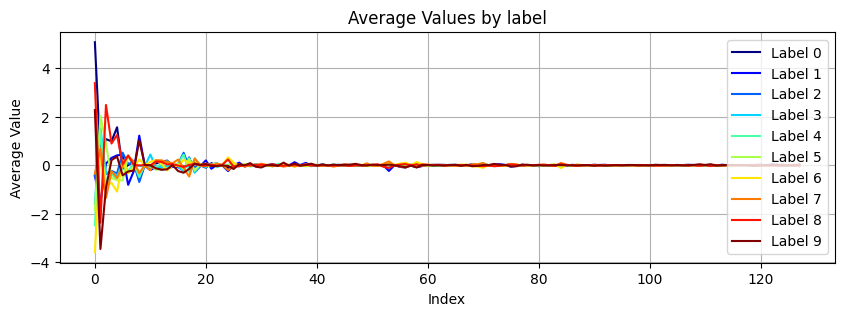

In [111]:
# training dataset is distributed equally
unique_values, counts = np.unique(original_train_label, return_counts = True)

collection = {}
    
for label in unique_values:
    label_indices = np.where(original_train_label == label)[0]
    class_data = original_train_data[label_indices]
    collection[label] = {'count': len(class_data),
                         'min': np.min(class_data),
                         'max': np.max(class_data),
                         'med': np.median(class_data),
                         'std': np.std(class_data),
                         'avg_val': np.mean(class_data, axis = 0)
    }

for label in unique_values:
    print(f'class {label}: count: {collection[label]["count"]}, min:{collection[label]["min"]:.2f}, max:{collection[label]["max"]:.2f}, med:{collection[label]["med"]:.2f}, std:{collection[label]["std"]:.2f}')

num_classes = len(collection)
colors = plt.cm.jet(np.linspace(0, 1, num_classes))  # Using the jet colormap, but you can choose others

plt.figure(figsize=(10, 3))
for i, (label, stats) in enumerate(collection.items()):
    avg_vals = stats['avg_val']  # Assuming this is a list of 128 average values
    indices = np.arange(len(avg_vals))  # Indices from 0 to 127
    plt.plot(indices, avg_vals, color=colors[i], label=f'Label {label}')

plt.title('Average Values by label')
plt.xlabel('Index')
plt.ylabel('Average Value')
plt.legend(loc='right')
plt.grid(True)
#plt.tight_layout()
plt.show()


## Pre-processing

In [112]:
# normalize dataset using train statistics
train_mean = np.mean(original_train_data)
train_std = np.std(original_train_data)
adj_train_data = (original_train_data - train_mean) / train_std
adj_test_data = (original_test_data - train_mean) / train_std

print(f'mean of adjusted train data: {np.mean(adj_train_data):.2f}, std dev: {np.std(adj_train_data):.2f}')

mean of adjusted train data: 0.00, std dev: 1.00


In [113]:
# resize and shuffle dataset

def resize_and_shuffle(input_data, input_label, proportion, random_state = None):
    '''
    resizes dataset by multiplying against proportion (0 to 1) and shuffle
    
    input:
    - input_data: array of train or test data as provided
    - input_label: array of train or test label as provided
    - propotion: float, proportion of data to be used
    - random_state: seed for randomizer, use for replicability 
    output:
    - output_data: shuffled data with length of proportion * len(input_data)
    - output_label: shuffled label with length of proportion * len(input_label)
    Notes:
    - pairs of (output_data, output_label) will still match as the index used is matched
    Example command:
    - resize_and_shuffle(original_train_data, original_train_label), proportion = 1, random_state = 42)
    '''
    
    #instantiate output list
    output_data = []
    output_label = []
    
    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion*len(label_indices)), replace=False)
        output_data.extend(input_data[selected_indices])
        output_label.extend(input_label[selected_indices])
    
    output_data = np.array(output_data)
    output_label = np.array(output_label)

    #reshuffle data because for some reason everything is grouped by class again
    shuffled_indices = np.arange(len(output_data))
    rs_generator.shuffle(shuffled_indices)
    output_data = output_data[shuffled_indices]
    output_label = output_label[shuffled_indices]
    
    #print output
    print(f'RESIZE AND SHUFFLE  >>> random_state: {random_state},  shape of data: {output_data.shape}')
    
    return output_data, output_label

In [114]:
# shuffle and train val split (and shuffle again)

def train_val_split(input_data, input_label, proportion = 0.8, random_state = None):
    '''
    train val split by a value of (proportion : 1-proportion) and shuffle
    
    input:
    - input_data: array of train data as provided
    - input_label: array of train label as provided
    - propotion: float, proportion of data to be assigned in train
    - random_state: seed for randomizer, use for replicability 
    output:
    - train_data: shuffled data with length of proportion * len(input_data)
    - tran_label: shuffled label with length of proportion * len(input_label)
    - val_data: shuffled data not included in train_data
    - val_label: shuffled label not included in train_label
    Notes:
    - pairs of (output_data, output_label) will still match as the index used is matched
    Example command:
    - 80:20 train val split >>> train_val_split(train_data, train_label), proportion = 0.8, random_state = 42)
    '''
    #instantiate output lists
    train_data, train_label, val_data, val_label = [],[],[],[]

    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)

    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion * len(label_indices)), replace=False)
        
        # populate lists. Anything that doesn't go to train, goes to val
        train_data.extend(input_data[selected_indices])
        train_label.extend(input_label[selected_indices])
        val_indices = np.setdiff1d(label_indices, selected_indices)
        val_data.extend(input_data[val_indices])
        val_label.extend(input_label[val_indices])

    #create arrays
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    val_data = np.array(val_data)
    val_label = np.array(val_label)

    # shuffle train data again for good measure
    train_shuffle_indices = np.arange(len(train_data))
    rs_generator.shuffle(train_shuffle_indices)
    train_data = train_data[train_shuffle_indices]
    train_label = train_label[train_shuffle_indices]
    
    # shuffle val data  again for good measure
    val_shuffle_indices = np.arange(len(val_data))
    rs_generator.shuffle(val_shuffle_indices)
    val_data = val_data[val_shuffle_indices]
    val_label = val_label[val_shuffle_indices]
    
    #prints
    print(f'TRAIN AND VAL SPLIT >>> random_state: {random_state}, shape of train: {train_data.shape}, shape of val: {val_data.shape}')
    print('') 
    return train_data, train_label, val_data, val_label

RESIZE AND SHUFFLE  >>> random_state: 42,  shape of data: (20000, 128)


TRAIN AND VAL SPLIT >>> random_state: 42, shape of train: (16000, 128), shape of val: (4000, 128)



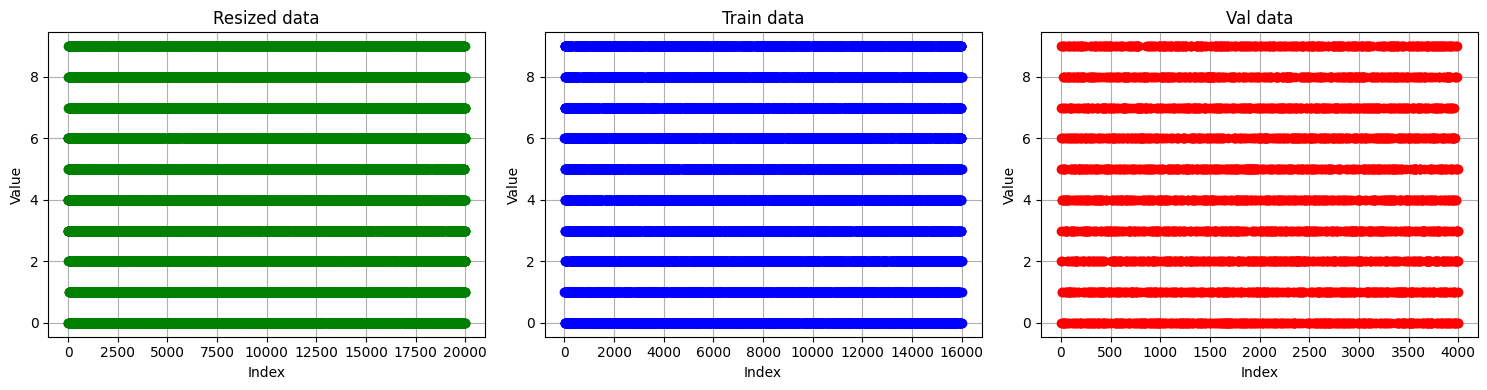

In [115]:
# test resize_and_shuffle and train_val_split
data_proportion = 0.4 # 0.4 x 50,000 = 20,000
train_proportion = 0.8 # 0.8 x 20,000 = 16,000 in train_data
random_state = 42
input_check, output_check = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data_check, train_label_check, val_data_check, val_label_check =train_val_split(input_check, output_check, proportion = train_proportion, random_state = 42)

# plot results, as long as data seems spread well, then the function works
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(output_check, marker='o', linestyle ='', color = 'green')
axs[0].set_title('Resized data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].grid(True)

# Plot for training data
axs[1].plot(train_label_check, marker='o', linestyle ='', color = 'blue')
axs[1].set_title('Train data')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].grid(True)

# Plot for validation data
axs[2].plot(val_label_check, marker='o', linestyle ='', color = 'red')
axs[2].set_title('Val data')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [116]:
# plot results and print scores

def plot_loss(input_data, batch_size, epoch_loss):
   
   #plot loss
   step = (len(input_data) / batch_size) 
   epoch_x_values = np.arange(step, (len(epoch_loss) + 1) * step, step)
   
   plt.figure(figsize=(15,5))
   plt.title('Cross entropy loss')

   # Plot epoch_loss as a red line
   plt.plot(epoch_x_values, epoch_loss, 'r-', label='Epoch loss')  # Red line for epoch loss

   plt.xlabel('Batches')
   plt.ylabel('Loss')
   plt.legend()
   plt.show()

def plot_loss_train_val(train_losses, val_losses, val_loss_interval=10, show_val=True, fig_size=(10,3), title=None):
   """
   Plots the training and validation losses.

   input:
   - train_losses: List of training losses.
   - val_losses: List of validation losses.
   - val_loss_interval: Interval at which validation losses were calculated (default is 10).
   - show_val: toggle to include/exclude val_losses in plot
   - fig_size: default size of plot
   """
   epochs = range(1, len(train_losses) + 1)
   val_epochs = [i * val_loss_interval for i in range(1, len(val_losses) + 1)]

   plt.figure(figsize=fig_size)  

   plt.plot(epochs, train_losses, 'b-', label='Training loss')
   if show_val:
      plt.plot(val_epochs, val_losses, 'r-', label='Validation loss')
   if title:
      plt.title(title)
   else: plt.title('Training and Validation loss')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.legend()
   plt.show()

def print_accuracy_f1(train_label, train_predict, test_label, test_predict):

   """
    Calculate training and testing scores based on model
   """
   train_accuracy = accuracy_score(train_label, train_predict)
   train_f1 = f1_score(train_label, train_predict, average='weighted')
   test_accuracy = accuracy_score(test_label, test_predict)
   test_f1 = f1_score(test_label, test_predict, average='weighted')
   print(f'                    >>> train accuracy: {train_accuracy:.2f}, train weighted f1: {train_f1:.2f}')
   print(f'test scores   >>> test accuracy: {test_accuracy:.2f}, test weighted f1: {test_f1:.2f}')

In [117]:
class Activation(object):
    
    '''
    Activation objects and their derivatives used in our MLP. This class contains:
    - tanh
    - sigmoid
    - relu
    - softmax

    Example command:
    - relu activation function >>> Activation("relu")
    '''
    #tanh
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    #sigmoid/logistic
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #relu
    def __relu(self, x):
        if np.isnan(x).any() or np.isinf(x).any():
            print("Detected NaN or Inf in x at relu")
        return np.maximum(0,x)
    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #leaky relu
    def __lrelu(self,x):
        return np.maximum(0.01*x,x)
    
    def __lrelu_deriv(self, a):
        return np.where(a>0,1,0.01)
    
    #softmax
    def __softmax(self,x, eps=1e-9): 
        ''' 
        softmax is applied to the output layer to calculate probabilities of each classes.
        argmax of exponential calculation is used in MLP to pick the predicted class with highest probability in the softmax layer.
        np.max is subtracted from the exponential calculation to guard against overflow issue.
        Thus the largest value of the exponential calculation is exp(0) = 1
        '''
        if np.isnan(x).any() or np.isinf(x).any():
            print("Detected NaN or Inf in x at softmax")
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        
        return exps / np.sum(exps, axis =-1, keepdims = True) + eps

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        gradient is approximated as the difference of predicted and true values.
        softmax gradient is not used in this model as softmax is only called in the output layer.
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'lrelu':
            self.f = self.__lrelu
            self.f_deriv = self.__lrelu_deriv

In [118]:
class HiddenLayer(object):    
    
    '''
    Hidden layer objects for our MLP. This class contains:
    - forward: forward propagation of input through linear transformation and activation in every layer
    - backward: backward propagation of errors/loss to calculate gradients, to be used in update (housed in the MLP class)
    - momentum: acceleration term to help escape saddle points (or very small gradients) on the objective curve
    - weight decay: penalty to the growth of weights in update (housed in MLP class) to avoid overfitting
    - dropout: assigns a mask with value 1 of probability (1-proportion), effectively retains / turns off nodes in layers during training
    - batchnorm_forward: application of batch normalization in forward propagation
    - batchnorm_backward: application of batch normalization in backward propagation

    Example command:
    - relu layer with 10 and 5 dimension input and output >>> HiddenLayer(10, 5, activation="relu")
    '''
    
    def __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, batch_size = 1, batchnorm_switch = True):
        """
        Fully connected hidden layer with default relu activation, overwrittable when HiddenLayer is called.
        :Param n_in: number of nodes in input.
        :Param n_out: number of nodes in output.
        :Param activation_last_layer: activation in output layer, default 'Softmax'.
        :Param activation: activation in input layer, default 'relu'.
        :Param W: weights of activation function, initialized with Xavier normalized initiation.
        :Param b: bias of activation function, initialized as zeros.
        :Param grad_W: derivative of W w.r.t. the loss function.
        :Param grad_b: derivative of b w.r.t. the loss function.
        :Param V_W: velocity of W, value to be updated with application of momentum and weight decay.
        :Param V_b: velocity of b, value to be updated with application of momentum and weight decay.
        :Param dropout_mask: boolean mask which assigns 1 with probability: (1-proportion), used in dropout.
        :Param gamma: scaling factor, used in batch normalization.
        :Param beta: shift factor, used in batch normalization.
        :Param grad_gamma: gradient of gamma, used in batch normalization.
        :Param grad_beta: gradient of beta, used in batch normalization.
        :Param running_mean: mean of input values along axis -1, updated during training with batch normalization. 
        :Param running_var: variance of input values along axis -1, updated during training with batch normalization.
        :Param cache: to store output of forward pass in batch normalization. values of cache is used in backward pass of batch normalization.

        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )


        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #initialize momentum
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        #initialize dropout mask
        self.dropout_mask = None

        #initialize batch normalization
        self.gamma = None
        self.beta = None
        self.grad_gamma = None
        self.grad_beta = None
        self.running_mean = np.zeros((batch_size,n_out))
        self.running_var = np.zeros((batch_size,n_out))
        self.cache = None

        #initialize adam
        self.V_dW = np.zeros(self.W.shape)
        self.S_dW = np.zeros(self.W.shape)
        self.V_db = np.zeros(self.b.shape)
        self.S_db = np.zeros(self.b.shape)
 
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input, dropout_rate, is_train = True, batchnorm_switch = True):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''

        #linear transformation
        lin_output = np.dot(input, self.W) + self.b 
        
        #batchnorm
        if batchnorm_switch:
            lin_output = self.batchnorm_forward(lin_output, is_train)
            #print(f'shape of batchnorm output: {lin_output.shape}')

        self.output = lin_output

        #dropout
        self.dropout(is_train, dropout_rate)
        
        if self.activation:
            self.output = self.activation(self.output)
        
        self.input=input

        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta, batchnorm_switch):         
        '''
        Note that the output_layer toggle is not used as backward pass calculation is uniform everywhere
        Note backward calculates grad_W and grad_b for the HiddenLayer object, while the iterator is housed in MLP
        '''

        #gradient
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 

        #dropout
        delta *= self.dropout_mask

        #batchnorm
        if batchnorm_switch:
            delta = self.batchnorm_backward(delta)

        #linear transformation
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

    
        return delta
    
    def momentum(self, momentum_gamma, lr):
        '''
        momentum is housed in HiddenLayer while the iterator in MLP
        '''
        self.V_W = momentum_gamma * self.V_W + lr * self.grad_W
        self.V_b = momentum_gamma * self.V_b + lr * self.grad_b 

    def weightdecay(self, lr, weight_decay):
        '''
        weight decay is only housed here, calculation based on lecture 4 slide 10, bottom middle
        '''
        self.W += lr * (weight_decay * self.W)

    def dropout(self, is_train, dropout_rate):

        #print(f'dropout function triggered, is_train = {is_train}, dropout_rate = {dropout_rate}')
        
        if is_train and dropout_rate > 0.0:
            self.dropout_mask = (np.random.rand(*self.output.shape) < (1 - dropout_rate))
            if np.isnan(self.dropout_mask).any() or np.isinf(self.dropout_mask).any():
                print("Detected NaN or Inf in dropout_mask in dropout")
            
        else:
            self.dropout_mask = np.ones_like(self.output)        

        self.output *= self.dropout_mask
        self.output *= 1/(1-dropout_rate)
    
    def batchnorm_forward(self,input, is_train = True, bn_momentum = 0.9, eps = 1e-9):
        '''
        Idea of BN momentum is from: Momentum Batch Normalization for Deep Learning with Small Batch Size
        Authors: Hongwei Yong, Jianqiang Huang, Deyu Meng, Xiansheng Hua, Lei Zhang
        Source: European Conference on Computer Vision
        Year: 2020

        https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb#:~:text=Test%20phase,that%20is%20calculated%20during%20training.
        https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
        '''
        #print('start bn forward')
        if self.gamma is None:
            self.gamma = np.ones((input.shape[-1]))
            self.beta = np.zeros((input.shape[-1]))
            self.grad_gamma = np.ones((input.shape))
            self.grad_beta = np.zeros((input.shape[-1]))

        if is_train:
            #calculate mean, variance, and normalized input
            batch_mean = np.mean(input, axis = 0)
            batch_var = np.var(input, axis = 0)
            batch_std = np.sqrt(batch_var + eps)
            input_centered = input - batch_mean
            input_normalized = input_centered/np.sqrt(batch_var + eps) #epsilon introduced to avoid divide by zero

            #use cache so backward pass isn't so painful
            self.cache = (input, input_normalized, batch_mean, batch_var)

            output = input_normalized * self.gamma + self.beta

            #update self.running_mean and self.running_var
            self.running_mean = bn_momentum * self.running_mean + (1-bn_momentum) * batch_mean
            self.running_var = bn_momentum * self.running_var + (1-bn_momentum) * batch_var

            self.cache = (input_normalized, input_centered, batch_std)

        else:
            input_normalized = (input - self.running_mean)/np.sqrt(self.running_var + eps)
            output = self.gamma * input_normalized + self.beta

        #print('')
        return output
    
    def batchnorm_backward(self, delta):
        
        #print('start bn backward')
        output_normalized, output_centered, batch_std = self.cache
        
        N,D = delta.shape
        
        #print(f'shape of delta:{delta.shape}')
        #print(f'shape of output_normalized: {output_normalized.shape}')
        self.grad_gamma = np.sum(delta * output_normalized, axis = 0)
        self.grad_beta = np.sum(delta, axis = 0)

        dx_normalized = delta * self.gamma
        dx_centered = dx_normalized / batch_std
        dmean = np.sum(-dx_centered, axis = 0) + 2/N * np.sum(output_centered, axis=0)
        dstd = np.sum((dx_normalized * output_centered * - batch_std**(-2)), axis = 0)
        dvar = dstd / 2/ batch_std
        dx = dx_centered + (dmean + dvar * 2 * output_centered) / N
        return dx
    
    def adam(self, iter, adam_learning_rate = 0.1, beta1 = 0.9, beta2 = 0.99, eps = 1e-9, adam_switch = True):
        '''Andrew Ng's explanation: https://www.youtube.com/watch?v=JXQT_vxqwIs
        '''
        #momentum
        self.V_dW = beta1 * self.V_dW + (1-beta1) * self.grad_W
        self.V_db = beta1 * self.V_db + (1-beta1) * self.grad_b
        
        #rms prop
        self.S_dW = beta2 * self.S_dW + (1-beta2) * (self.grad_W ** 2)
        self.S_db = beta2 * self.S_db + (1-beta2) * (self.grad_b ** 2)
        
        #correction
        self.V_dW = self.V_dW / (1 - (beta1 ** iter))
        self.V_db = self.V_db / (1 - (beta1 ** iter))
        self.S_dW = self.S_dW / (1 - (beta2 ** iter))
        self.S_db = self.S_db / (1 - (beta2 ** iter))

        #calculate adjustments
        adam_W = adam_learning_rate * self.V_dW / (np.sqrt(self.S_dW)+eps)
        adam_b = adam_learning_rate * self.V_db / (np.sqrt(self.S_db)+eps)
        
        return adam_W, adam_b

In [119]:
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer. Should be at least two values
        :param activation: The activation function to be used. Can be "logistic" or "tanh"
        """

        # __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, dropout_rate = 0.0)        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, dropout_rate, batchnorm_switch, is_train = True):
        #print(f'dropout rate in MLP.forward: {dropout_rate}')
        for layer in self.layers:
            output=layer.forward(input, dropout_rate, is_train, batchnorm_switch)
            input=output
        return output

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat, batch_size, eps=1e-9):
        '''
        shape of y = (1,) <-- a single integer of true class
        shape of y_hat = (10,) <-- values corresponding to each class
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[1] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y = y.flatten().astype(int)
        y_one_hot[np.arange(num_samples),y] = 1 

        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + eps)) /  batch_size #adjusting loss by batch_size for minibatch
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta, batchnorm_switch):
        delta=self.layers[-1].backward(delta, batchnorm_switch)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta = layer.backward(delta, batchnorm_switch)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,momentum_gamma,lr, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate):
        #print(f'start update')
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, f'mismatch in W{layer.W.shape} and grad_W {layer.grad_W.shape} shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            
            #call momentum from HiddenLayer to update V values
            layer.momentum(momentum_gamma,lr)
            
            #call weightdecay from hiddenlayer to update V values
            layer.weightdecay(lr, weight_decay)

            #apply adjustments to V_W to W
            if adam_switch:
                self.adam_counter += 1
                adam_W, adam_b = layer.adam(self.adam_counter, adam_learning_rate = adam_learning_rate, beta1 = 0.9, beta2 = 0.99, eps = 1e-9, adam_switch = True)
                layer.W -= adam_W
                layer.b -= adam_b
            else:
                layer.W -= layer.V_W
                layer.b -= layer.V_b

            #batchnorm update
            if batchnorm_switch:
                layer.gamma -= lr * layer.grad_gamma
                layer.beta -= lr * layer.grad_beta

    '''minibatch added here. n = 1 is SGD, n = N is batch n = n is minibatch'''
    def getBatch(self, X,y, batch_size):
        
        '''
        output: tuples of (X,y) with length = batch_size
        '''
        #exceptions
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'length of data ({X.shape[0]}) not equal to length of label ({y.shape[0]})')
        if batch_size > X.shape[0]:
            raise ValueError(f'batch_size = {batch_size} > data count: {X.shape[0]}')
        
        #mini batch 
        if batch_size <= X.shape[0]:
            # for loop below drops the last batch, just in case it is too small
            for start_index in range(0, X.shape[0] - batch_size + 1, batch_size):
                end_index = min(start_index + batch_size, X.shape[0])
                #print(f'start_index: {start_index}, end_index: {end_index}')
                #print(f'X:{X[start_index:end_index]}, y:{y[start_index:end_index]}')
                yield X[start_index:end_index], y[start_index:end_index]

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X_train,y_train, X_val, y_val, momentum_gamma =0.9, learning_rate=0.1, epochs=100, batch_size =1, weight_decay = 0.01, dropout_rate = 0.0, early_stopping =[5,10], batchnorm_switch = True, adam_switch = True, adam_learning_rate = 0.1):
       
        #print(f'FITTING             >>> dropout_rate: {dropout_rate}, momentum gamma: {momentum_gamma}, learning_rate: {lr}, epochs: {epochs}, batch_size:{batch_size}')
       
        #insert assert for data and label for train and val

        validate_check = len(X_val) > 0 and len(y_val) > 0

        if validate_check is False:
            print('No validation data provided, skipping validation step')

        #instantiate toggles for early_stopping
        is_early_stop = False
        last_validation_loss = float('inf') if validate_check else None
        epoch = 0
        count = 0
        MAX_COUNT = early_stopping[0]
        EVAL_TRIGGER = early_stopping[1]

        # assign X_train and y_train to X and y 
        X=np.array(X_train)
        y=np.array(y_train)
        epoch_losses = []
        val_losses = []
        
        #starm adam_counter at 0
        self.adam_counter = 0

        #loop over epochs
        #print(f'FITTING (STAGE 1)   >>> training to be stopped when val score does not improve in {MAX_COUNT} cycles ({MAX_COUNT * EVAL_TRIGGER} epochs)')
       
        for k in range(epochs):
            #print(f'dropout rate in fit epoch {k}: {dropout_rate}')
            #print(f'start epoch {k}')
            epoch_loss = self.train_loop(X, y, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)
            epoch_losses.append(epoch_loss)

            #implement early stop
            if validate_check and k % EVAL_TRIGGER == 0:
                current_validation_loss = self.eval(X_val, y_val, dropout_rate, batchnorm_switch)
                
                if current_validation_loss > last_validation_loss:
                    count += 1

                    if count == MAX_COUNT:
                        #print(f'                    >>> early stopping at epoch {k}')
                        is_early_stop = True
                        early_stop_train_score = epoch_loss
                        break
                
                else:
                    last_validation_loss = current_validation_loss
                    count = 0

                if not is_early_stop:
                    val_losses.append(current_validation_loss)
                    
            epoch += 1

        if validate_check and is_early_stop:
            #print('FITTING (STAGE 2)   >>> Continuing training with train + val data')
            X_combined = np.concatenate((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))

            while epoch < epochs:
                epoch +=1
                epoch_loss = self.train_loop(X_combined, y_combined, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)
                epoch_losses.append(epoch_loss)
                
                if epoch_loss < early_stop_train_score:
                    #print(f'                    >>> training stopped at epoch {epoch} -- training loss achieved')
                    break
                #elif (epoch == epochs):
                    #print(f'                    >>> training stopped at epoch {epoch} -- maximum epochs achieved')
        #print(f'         >>> train loss:{epoch_losses[-1]:.2f}, val loss: {val_losses[-1]:.2f}' if len(val_losses) >0 else f'                    >>> train loss:{epoch_losses[-1]:.2f}, val loss: None')
        return epoch_losses, val_losses, epoch

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x, dropout_rate, batchnorm_switch):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :],dropout_rate, batchnorm_switch, is_train = False)  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output
    
    def eval(self, X_val, y_val, dropout_rate,batchnorm_switch):
        #print('eval triggered')
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        yhat_val = self.forward(X_val, dropout_rate, batchnorm_switch, is_train=False) # we don't use predict because it will cause issues in criterion cross entropy  
        #print('x')
        val_loss, _ = self.criterion_cross_entropy(y_val,yhat_val, len(y_val))
        #print('end of eval')
        return np.mean(val_loss)
    
    def train_loop(self, X, y, batch_size, dropout_rate, momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate):
        #spits out epoch loss
                    
        total_loss = 0 #sum up batch_losses for every epoch
        batches = 0 #count number of batches, e.g. 1,2,3,4
        #print('y')
        
        for X_batch, y_batch in self.getBatch(X,y,batch_size):
            #print('x')
            # forward pass
            y_hat = self.forward(X_batch, dropout_rate, batchnorm_switch, is_train = True)
            #print(y_hat.shape)
            
            # compute loss and gradient
            loss,delta=self.criterion_cross_entropy(y_batch,y_hat, batch_size)

            #backward pass
            self.backward(delta, batchnorm_switch)

            # update
            self.update(momentum_gamma, learning_rate, weight_decay, batchnorm_switch, adam_switch, adam_learning_rate)

            #record batch loss in batch losses
            batch_loss = np.mean(loss)
            batches += 1
            total_loss += batch_loss
            #print(f'batches:{batches}')
            
            #print(y_batch)
            #print(f'Epoch: {k}, batch: {batches}, X_batch dim: {X_batch.shape}, y_batch dim: {y_batch.shape}, loss: {loss}')

        epoch_loss = total_loss / batches

        return epoch_loss

## Hyperparameter Testing

In [120]:
# pick data proportion and train val split
data_proportion = 1
random_state = 42
train_proportion = .8
input_data, input_label = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data, train_label, val_data, val_label = train_val_split(input_data, input_label, proportion = train_proportion, random_state = random_state)


RESIZE AND SHUFFLE  >>> random_state: 42,  shape of data: (50000, 128)
TRAIN AND VAL SPLIT >>> random_state: 42, shape of train: (40000, 128), shape of val: (10000, 128)



In [121]:
# hyperparameter tuning function
def hyperparamater_testing(parameters):
    learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations = parameters
    sumproduct = (len(learning_rates) * len(batch_sizes) * len(early_stopping_combination) * len(epoch_counts) * len(momentum_gammas) * len(weight_decays) * len(dropouts) * len(batchnorm_switches) * len(adam_learning_rates) * len(node_counts))
    print(f'Running {sumproduct} cases.')
    
    assets = []
    counter = 0
    for early_stopping in early_stopping_combination:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                for epoch_count in epoch_counts:
                    for momentum_gamma in momentum_gammas:
                        for weight_decay in weight_decays:
                            for dropout in dropouts:
                                for batchnorm_switch in batchnorm_switches:
                                    for adam_learning_rate in adam_learning_rates:
                                        
                                        if adam_learning_rate > 0:
                                            adam_switch = True
                                        else: adam_switch = False

                                        for (node_count, node_activation) in zip(node_counts, node_activations):
                                            
                                            nn = MLP(node_count, node_activation)

                                            start_time = time.time()

                                            train_loss, val_loss, epoch = nn.fit(train_data, train_label, val_data, val_label, 
                                                            momentum_gamma = momentum_gamma, learning_rate = lr, 
                                                            epochs = epoch_count, batch_size = batch_size, 
                                                            weight_decay = weight_decay, dropout_rate = dropout, 
                                                            early_stopping = early_stopping, batchnorm_switch = batchnorm_switch, 
                                                            adam_switch = adam_switch, adam_learning_rate = adam_learning_rate)
                                            
                                            end_time = time.time()

                                            duration = end_time - start_time
                                            duration_minutes, duration_seconds = int(duration // 60), int(duration % 60)

                                            train_predict = nn.predict(train_data, dropout_rate = 0, batchnorm_switch = batchnorm_switch)
                                            test_predict = nn.predict(adj_test_data, dropout_rate = 0, batchnorm_switch = batchnorm_switch) 
                                            
                                            train_accuracy, train_f1 = accuracy_score(train_label, train_predict), f1_score(train_label, train_predict, average='weighted')
                                            test_accuracy, test_f1 = accuracy_score(original_test_label, test_predict), f1_score(original_test_label, test_predict, average='weighted')
                                        
                                            #print(f"CASE {counter}   >>> duration: {duration_minutes}m{duration_seconds}s")

                                            counter += 1
                                            assets.append({
                                                'case': counter,
                                                'early_stopping': early_stopping,
                                                'batch_size': batch_size,
                                                'learning_rate': lr,
                                                'duration_minutes': duration_minutes,
                                                'duration_seconds': duration_seconds,
                                                'epochs': epoch,
                                                'train_loss': train_loss,
                                                'val_loss': val_loss,
                                                'train_accuracy': train_accuracy,
                                                'train_f1': train_f1,
                                                'test_accuracy': test_accuracy,
                                                'test_f1': test_f1,
                                                'node_count': node_count,
                                                'node_activation': node_activation,
                                                'batchnorm_switch': batchnorm_switch,
                                                'dropout_rate':dropout,
                                                'weight_decay':weight_decay,
                                                'adam_learning_rate': adam_learning_rate
                                            })

    return assets


In [122]:
#plot function, plt show not included so we can plot in grid
def multi_plotter(assets, target, label_keys, marker_param, line_param, color_param, fig_size =(14,7)):
    
    #import cycle
    from itertools import cycle

    #Plot size
    plt.figure(figsize=fig_size)  

    # Markers, line styles, and colors
    markers = cycle(['o', 's', 'D', '^', 'x', '*', '+'])  # Cycle through these markers
    linestyles = cycle(['solid', 'dashed', 'dotted', 'dashdot'])  # Cycle through these line styles
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])  # Cycle through these colors

    #make lists hasable (e.g. early_stopping)
    make_hashable = lambda x: tuple(x) if isinstance(x, list) else x

    marker_map = {make_hashable(value): next(markers) for value in set(make_hashable(asset.get(marker_param, 'default_marker')) for asset in assets)} if marker_param else {}
    linestyle_map = {make_hashable(value): next(linestyles) for value in set(make_hashable(asset.get(line_param, 'default_linestyle')) for asset in assets)} if line_param else {}
    color_map = {make_hashable(value): next(colors) for value in set(make_hashable(asset.get(color_param, 'default_color')) for asset in assets)} if color_param else {}

    for asset in assets:
        # Generate a range of epochs for the x-axis
        epochs = range(1, len(asset['train_loss']) + 1)
        case_label = ', '.join([f"{key}:{asset[key]}" for key in label_keys])
        
        marker = marker_map.get(make_hashable(asset.get(marker_param, 'default_marker')), None) if marker_param else None
        linestyle = linestyle_map.get(make_hashable(asset.get(line_param, 'default_linestyle')), 'solid') if line_param else 'solid'
        color = color_map.get(make_hashable(asset.get(color_param, 'default_color')), 'black') if color_param else next(colors)
        
        # Plot train loss for this case
        plt.plot(epochs, asset[target], label=case_label, linestyle=linestyle, color=color, marker = marker)

In [123]:
# filter function
def filter_asset(assets, filter_key = None, filter_value = None, columns_to_show = None):
    data_for_df = []
    
    for asset in assets:
        # Extract final train and validation loss values
        final_train_loss = asset['train_loss'][-1] if asset['train_loss'] else None
        final_val_loss = asset['val_loss'][-1] if asset['val_loss'] else None
        
        #transform early_stopping into str so we can filter over it
        #early_stopping_str = str(asset['early_stopping']) if isinstance(asset['early_stopping'], list) else asset['early_stopping']

        # Prepare a dictionary for each row in the DataFrame
        row = {
            'case': asset['case'],
            'batch_size': asset['batch_size'],
            'learning_rate': asset['learning_rate'],
            'early_stopping': asset['early_stopping'],
            'node_count': asset['node_count'],
            'node_activation': asset['node_activation'],
            'batchnorm_switch': asset['batchnorm_switch'],
            'dropout_rate':asset['dropout_rate'],
            'weight_decay':asset['weight_decay'],
            'adam_learning_rate':asset['adam_learning_rate'],
            'train_loss': round(final_train_loss,2),
            'val_loss': round(final_val_loss,2),
            'train_accuracy': round(asset.get('train_accuracy'),2),  # Using .get in case the key might not exist
            'train_F1': round(asset.get('train_f1'),2),
            'test_accuracy': round(asset.get('test_accuracy'),2),
            'test_F1': round(asset.get('test_f1'),2),
            'epochs': len(asset['train_loss']),  # Assuming this reflects the number of epochs run
            'duration': f"{asset.get('duration_minutes')}m{asset.get('duration_seconds')}s"
        }
        
        data_for_df.append(row)

    # Create DataFrame
    df = pd.DataFrame(data_for_df)

    #if no filter keys are stated, return full df
    if filter_key and filter_value:
        if isinstance(filter_value, list):
            # Handle list comparison directly without converting to string
            df = df[df[filter_key].apply(lambda x: x == filter_value)]
        else:
            # Direct comparison for non-list values
            df = df[df[filter_key] == filter_value]

    if columns_to_show:
        df = df[columns_to_show]

    return df

### Experiment 4: dropout


In [139]:
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [200]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.2]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10],
               [128,64,64,10]] 

node_activations = [[None,'relu','relu','softmax'],
                    [None,'lrelu','lrelu','softmax']]

#wrap
parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

assets_exp_4b = hyperparamater_testing(parameters)

columns_to_show =['node_activation', 'train_loss','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_4b, columns_to_show=columns_to_show)

Running 2 cases.


,node_activation,train_loss,train_accuracy,train_F1,test_accuracy,test_F1,epochs,duration
0,"[None, relu, relu, softmax]",1.78,0.50,0.50,0.44,0.44,201,3m48s
1,"[None, lrelu, lrelu, softmax]",1.70,0.54,0.53,0.49,0.48,201,3m41s


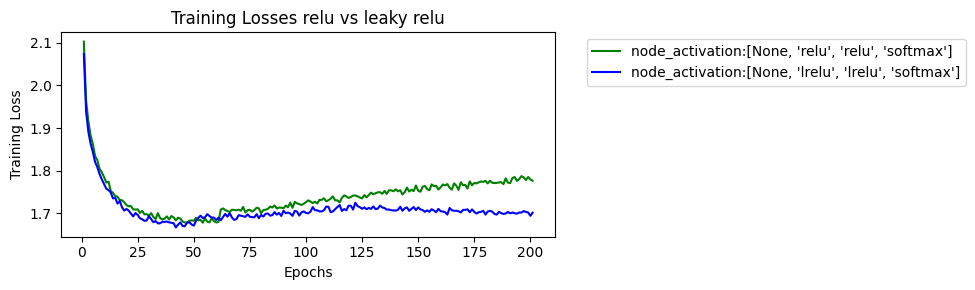

In [140]:
target ='train_loss'
label_keys =['node_activation']  
marker_param = None
line_param = None
color_param = 'node_activation'

multi_plotter(assets_exp_4b, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

plt.title('Training Losses relu vs leaky relu')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [127]:
learning_rates = [0.001]
batch_sizes = [100]
early_stopping_combination = [[3,10]]
epoch_counts = [200]
momentum_gammas = [0.0]
weight_decays = [0.0]
dropouts = [0.0, 0.2, 0.5]
batchnorm_switches = [False]
adam_learning_rates = [0.00]
node_counts = [[128,64,64,10]] 
node_activations = [[None,'relu','relu','softmax']]

#wrap
parameters = (learning_rates,batch_sizes,early_stopping_combination, epoch_counts, momentum_gammas, weight_decays, dropouts, batchnorm_switches,adam_learning_rates, node_counts,node_activations)

assets_exp_4 = hyperparamater_testing(parameters)

columns_to_show =['dropout_rate','train_accuracy','train_F1','test_accuracy','test_F1','epochs','duration']
filter_asset(assets_exp_4, columns_to_show=columns_to_show)

Running 3 cases.


KeyboardInterrupt: 

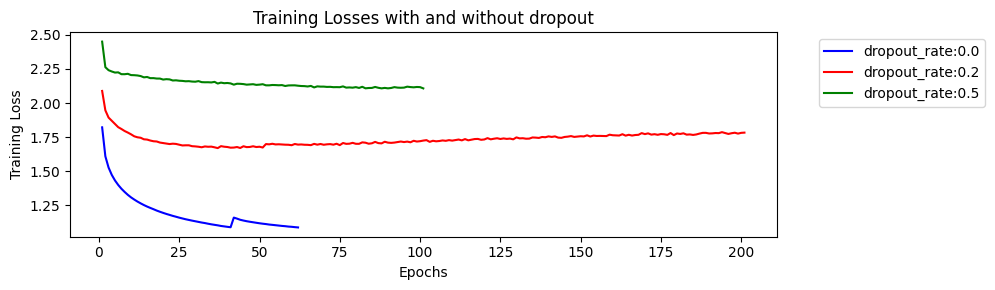

In [ ]:
target ='train_loss'
label_keys =['dropout_rate']  
marker_param = None
line_param = None
color_param = 'dropout_rate'

multi_plotter(assets_exp_4, target, label_keys, marker_param, line_param, color_param, fig_size =(10,3))

plt.title('Training Losses with and without dropout')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()